In [1]:
import cv2
import numpy as np
import math
# from src.utils import *
from matplotlib import pyplot as plt
from utils import *


%matplotlib inline
%load_ext autoreload
%autoreload 2

Width: 112
Height: 112
Frame Count: 84


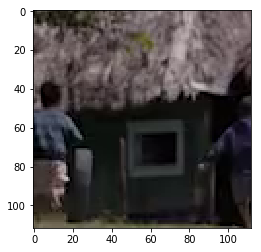

In [8]:
# test the basic information of video
cap = cv2.VideoCapture('../media/video_3_right_wipe.mp4')
if not cap.isOpened():
    print("Open video failed")

height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print("Width: {}".format(width))
print("Height: {}".format(height))
print("Frame Count: {}".format(frame_count))
# show RGB first frame
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, some_frame = cap.read()
plt.imshow(cv2.cvtColor(some_frame, cv2.COLOR_BGR2RGB))

In [9]:
# test `to_sti_column(cap)`
# create sti of all columns
sti_columns = np.ndarray((width, height, frame_count, 3), dtype=np.uint8)
for i in range(width):
    sti_columns[i] = to_sti_column(cap, i)


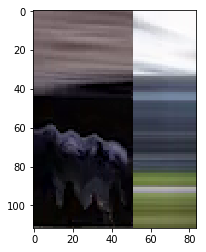

In [10]:
# show one sti_column
sti_column_rgb = cv2.cvtColor(sti_columns[99], cv2.COLOR_BGR2RGB)
plt.imshow(sti_column_rgb)

In [11]:
# BGR -> GR
sti_columns_rg = np.ndarray(list(sti_columns.shape[:-1]) + [2], dtype=np.float32)
for i in range(width):
    sti_columns_rg[i] = bgr_to_rg(sti_columns[i])

In [12]:
# print gr channel of certain sti_column
print(sti_columns_rg[0])

[[[0.42028973 0.36231872]
  [0.42028973 0.36231872]
  [0.42028973 0.36231872]
  ...
  [0.17231637 0.33050844]
  [0.16949151 0.3333333 ]
  [0.1735537  0.3333333 ]]

 [[0.45833308 0.3749998 ]
  [0.45833308 0.3749998 ]
  [0.45833308 0.3749998 ]
  ...
  [0.17231637 0.33050844]
  [0.16949151 0.3333333 ]
  [0.1735537  0.3333333 ]]

 [[0.42857125 0.36507922]
  [0.42857125 0.36507922]
  [0.42857125 0.36507922]
  ...
  [0.17366946 0.3305322 ]
  [0.17086834 0.3333333 ]
  [0.17486337 0.3333333 ]]

 ...

 [[0.37012982 0.34740257]
  [0.36496347 0.3576642 ]
  [0.36184207 0.3552631 ]
  ...
  [0.38762212 0.3387622 ]
  [0.38870427 0.3388704 ]
  [0.3892617  0.33892614]]

 [[0.37123743 0.34782606]
  [0.36332175 0.35640135]
  [0.36129028 0.35483867]
  ...
  [0.388535   0.35031843]
  [0.3890675  0.35048229]
  [0.38961035 0.35064933]]

 [[0.37454543 0.34909087]
  [0.36496347 0.3576642 ]
  [0.36241606 0.35570467]
  ...
  [0.388535   0.35031843]
  [0.3890675  0.35048229]
  [0.3890675  0.35048229]]]


In [18]:
# implements histogram intersection on GR color channels

bin_size = 1 + math.floor(math.log(height, 2))

HISTOGRAM_INTERSECTION_THRESHOLD = 0.7  # I[i] greater than this value is regarded is in the same scene

# create np.3darray with shape (frame_count, bin_size, bin_size)
H = np.ndarray((width, frame_count, bin_size, bin_size))

# compute hist for one column from STI
for col in range(width):
    for f in range(frame_count):
        H[col, f] = normalize(cal_hist_rg(sti_columns_rg[col, :, f:f + 1, :], bin_size))
        
# create np.1darray for histogram intersection
I = np.ndarray((width, frame_count - 1))

# contruct the column * frame graph
wipe_cols = []
wipe_frames = []
for col in range(width):
#     print("in column: {}".format(col))
    for f in range(I.shape[1]):
        # I[i] intersects histogram of frames at time i+1 and i
        I[col, f] = np.sum(np.minimum(H[col, f + 1], H[col, f]))
        # TODO: add cooldown time to avoid several continuous frames are all regraded as wipe
        if I[col, f] < HISTOGRAM_INTERSECTION_THRESHOLD:
            wipe_cols.append(col)
            wipe_frames.append(f)
#             print("Wipe at: {}".format(f + 1))
            
wipe_cols = np.array(wipe_cols).reshape(-1, 1)
wipe_frames = np.array(wipe_frames).reshape(-1, 1)
print(wipe_cols.shape)
print(I[99])

(32, 1)
[0.85714289 0.98214289 0.95535717 0.96428571 0.66964287 0.88392858
 0.83035715 0.99107142 0.79464287 0.83928572 0.88392856 0.75892857
 0.9375     0.89285712 0.93749998 0.9017857  0.84821427 0.89285718
 0.90178573 0.94642858 0.91071429 0.91964287 0.91964287 0.83035715
 0.90178572 0.94642859 0.87499999 0.91071427 0.91071432 0.83928574
 0.97321431 0.90178569 0.86607144 0.88392858 0.89285716 0.89285713
 0.92857146 0.98214286 0.86607144 0.96428573 0.95535717 0.79464287
 0.92857144 0.82142858 0.86607142 0.92857143 0.83035715 0.92857145
 0.93750001 0.79464286 0.47321427 0.99999999 0.97321427 0.96428572
 0.97321431 1.00000002 0.98214283 0.99999998 0.92857143 0.95535715
 0.99107141 1.         0.99107143 0.99107143 0.99999997 0.97321425
 0.99107145 1.00000003 0.93750003 1.00000003 1.00000003 0.93750003
 1.00000003 1.00000003 0.98214284 0.99999997 0.99999997 0.95535716
 0.95535716 0.99999997 0.96428569 0.98214288 1.00000001]


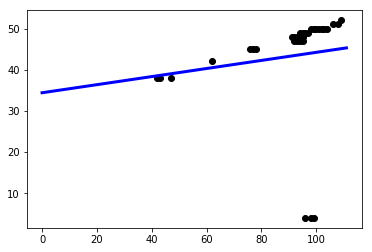

start/end frame: [34. 45.]
[[ 42]
 [ 43]
 [ 47]
 [ 62]
 [ 76]
 [ 77]
 [ 78]
 [ 91]
 [ 92]
 [ 92]
 [ 93]
 [ 93]
 [ 94]
 [ 94]
 [ 95]
 [ 95]
 [ 95]
 [ 96]
 [ 96]
 [ 97]
 [ 98]
 [ 98]
 [ 99]
 [ 99]
 [100]
 [101]
 [102]
 [103]
 [104]
 [106]
 [108]
 [109]]


In [16]:
# linear regression using sklearn
from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit(wipe_cols, wipe_frames)

cols_test = np.array([0, width - 1]).reshape(-1, 1)
frames_pred = regr.predict(cols_test)

plt.scatter(wipe_cols, wipe_frames,  color='black', linewidths=1)
plt.plot(cols_test, frames_pred, color='blue', linewidth=3)

# plt.xticks(())
# plt.yticks(())

plt.show()
print("start/end frame: {}".format(np.round(sorted(frames_pred.flatten()))))
print(wipe_cols)

In [9]:
print(__doc__)


# Code source: Jaques Grobler
# License: BSD 3 clause


import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Load the diabetes dataset
diabetes = datasets.load_diabetes()
print("Type of diabetes: {}".format(type(diabetes)))

# X axis
diabetes_X = diabetes.data[:, np.newaxis, 2]
print("Type of diabetes_X: {}".format(type(diabetes_X)))
print("Shape of diabetes_X: {}".format((diabetes_X.shape)))
print("{}".format(diabetes_X[:10]))

# Y axis (tag)

print("Type of diabetes.target: {}".format(type(diabetes.target)))
print("Shape of diabetes.target: {}".format((diabetes.target.shape)))
print("{}".format(diabetes.target[:10]))

Automatically created module for IPython interactive environment
Type of diabetes: <class 'sklearn.utils.Bunch'>
Type of diabetes_X: <class 'numpy.ndarray'>
Shape of diabetes_X: (442, 1)
[[ 0.06169621]
 [-0.05147406]
 [ 0.04445121]
 [-0.01159501]
 [-0.03638469]
 [-0.04069594]
 [-0.04716281]
 [-0.00189471]
 [ 0.06169621]
 [ 0.03906215]]
Type of diabetes.target: <class 'numpy.ndarray'>
Shape of diabetes.target: (442,)
[151.  75. 141. 206. 135.  97. 138.  63. 110. 310.]


In [67]:
# Split the data into training/testing sets
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]

# Split the targets into training/testing sets
diabetes_y_train = diabetes.target[:-20]
diabetes_y_test = diabetes.target[-20:]

In [68]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(diabetes_X_train, diabetes_y_train)

# Make predictions using the testing set
diabetes_y_pred = regr.predict(diabetes_X_test)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [77]:
# print the type of test, pred
print("Type of diabetes_X_test: {}".format(type(diabetes_X_test)))
print("Shape of diabetes_X_test: {}".format((diabetes_X_test.shape)))
print("{}".format(diabetes_X_test[:10]))

Type of diabetes_X_test: <class 'numpy.ndarray'>
Shape of diabetes_X_test: (20, 1)
[[ 0.07786339]
 [-0.03961813]
 [ 0.01103904]
 [-0.04069594]
 [-0.03422907]
 [ 0.00564998]
 [ 0.08864151]
 [-0.03315126]
 [-0.05686312]
 [-0.03099563]]


Coefficients: 
 [938.23786125]
Mean squared error: 2548.07
Variance score: 0.47


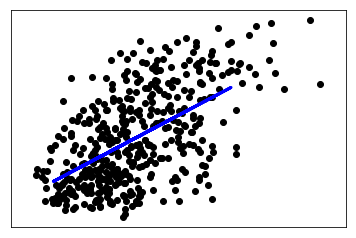

In [74]:


# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(diabetes_y_test, diabetes_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(diabetes_y_test, diabetes_y_pred))

# Plot outputs
plt.scatter(diabetes_X_train, diabetes_y_train,  color='black')
plt.scatter(diabetes_X_test, diabetes_y_test,  color='black')
plt.plot(diabetes_X_test, diabetes_y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()